In [221]:
import numpy as np
import datetime
import matplotlib.pyplot as plt
import shutil
import os
import copy
from netCDF4 import Dataset
# from numba import jit
from scipy import stats
from scipy import sparse
from scipy.ndimage.filters import gaussian_filter
# from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import shapely.vectorized
proj_cart = ccrs.PlateCarree() 
import grid_set as gs
from imp import reload
reload(gs)

<module 'grid_set' from '/Users/h/Github/geo_data_group/grid_set.py'>

In [56]:
m = 30
n = 30
test_in  = np.ones([m,n])

varr = np.ones([m,n],dtype=int)
varc = np.ones([m,n],dtype=int)
mask = np.ones([m,n],dtype=bool)

In [28]:
varr[10:20,12:20] = 4
varc[10:20,10:18] = 3
mask[12:16,13:17] = False

In [41]:

ii,jj = varc.shape
ijl = []
vvl = []
ddl = []
for i in range(ii):
    for j in range(jj):
        ## i,j are the target indicies
        if mask[i,j] == False: break
        ij = np.ravel_multi_index((i,j),(ii,jj))
        ## i+-varr[i,j]
        ## j+-varc[i,j]
        ## are the target indice
        ## place in the sparse matrix is np.ravel_multi_index((i,j))
        vij = []
        for vi in range(i-varr[i,j],i+varr[i,j]+1):
            for vj in range(j-varc[i,j],j+varc[i,j]+1):
#                 if (vi in range(ii)) and (vj in range(jj)):
                if (vi in range(ii)) and (vj in range(jj)) and mask[vi,vj]:
                    vij.append(np.ravel_multi_index((vi,vj),(ii,jj)))
        ## here is point for making a different kernel
        ## current is box
        weight = 1/np.shape(vij)[0]
#         if np.shape(vij)[0] > 1: print(weight)
        for vv in vij:
            ijl.append(ij)
            vvl.append(vv)
            ddl.append(weight)

In [42]:
len(ijl)

9302

In [45]:
# %timeit mat1 = sparse.coo_matrix((ddl, (ijl, vvl)))
mat1 = sparse.coo_matrix((ddl, (ijl, vvl)))

In [46]:

%timeit matrix = mat1.tocsr()

108 µs ± 1.99 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
#### masking saves time proportional to no. of masked points

In [222]:
m = ccrs.LambertAzimuthalEqualArea(central_latitude=90)
G = gs.grid_set(m)
# G.load_grid('/Users/h/PREMELT/Budget/Budget_tool/grids/Pathfinder_gs.npz')
# G.load_mask('/Users/h/PREMELT/Budget/Budget_tool/grids/Pathfinder_gs_mask.npz')
G.load_grid('/Users/h/PREMELT/Budget/Budget_tool/grids/CICE_1deg_gsT.npz')
G.load_mask('/Users/h/PREMELT/Budget/Budget_tool/grids/CICE_1deg_gs_maskT.npz')

Loaded a grid: /Users/h/PREMELT/Budget/Budget_tool/grids/CICE_1deg_gsT.npz
Loaded mask,  104  x  129  inflated by  0.0


In [227]:
G.gridinfo = False
G.get_grid_info()

Grid distances calculated:  54032.78806193819  x  54517.01141391502


/Users/h/Github/geo_data_group/grid_set.py:1193: RuntimeWarning: invalid value encountered in cos
  C_lat=np.cos(lat2);
/Users/h/Github/geo_data_group/grid_set.py:1194: RuntimeWarning: invalid value encountered in sin
  S_lat=np.sin(lat2);
/Users/h/Github/geo_data_group/grid_set.py:1195: RuntimeWarning: invalid value encountered in cos
  C_lon=np.cos(lon2);
/Users/h/Github/geo_data_group/grid_set.py:1196: RuntimeWarning: invalid value encountered in sin
  S_lon=np.sin(lon2);


Angles calculated


In [228]:
G.save_grid_nc('/Users/h/PREMELT/CICE_analysis/CICE_1deg.nc')

In [203]:
testsm1 = gs.geo_vary_smooth(G,100e3,verbos=True)

Bulding vary smoother, av cell dist = [4.0, 4.3], [4.0, 4.3]
Smooth martix, entries = 7645877, mean weights = 0.02


In [174]:
testsm2 = gs.geo_vary_smooth(G,100e3,mask=more_mask,verbos=True)

Bulding vary smoother, av cell dist = [4.0, 4.3], [4.0, 4.3]
Smooth martix, entries = 3480440, mean weights = 0.02


In [214]:
testsm3 = gs.geo_vary_smooth(G,200e3,mask=more_mask,verbos=True)

Bulding vary smoother, av cell dist = [7.9, 8.5], [7.9, 8.5]
Smooth martix, entries = 7314587, mean weights = 0.00


In [159]:

testsm3 = gs.geo_vary_smooth(G,100e3,mask=more_mask,verbos=True)

Bulding vary smoother, av cell dist = [4.0, 4.3], [4.0, 4.3]
Smooth martix, entries = 1079107, mean weights = 0.02


In [95]:
G.get_grid_mask()

In [208]:
more_mask = np.isfinite(G.mask)

In [209]:
more_mask[G.lats<50] = False

In [120]:
np.sum(more_mask)

21859

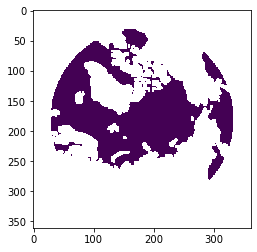

In [212]:
plt.imshow(testsm3.smooth(more_mask))

In [204]:
%timeit testsm1.smooth(more_mask)

14.7 ms ± 49.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [197]:
%timeit testsm2.smooth(more_mask)

/Users/h/Github/geo_data_group/grid_set.py:1580: RuntimeWarning: invalid value encountered in true_divide
  narray = narray/dweight


8.11 ms ± 221 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [196]:
%timeit testsm3.smooth(more_mask)

/Users/h/Github/geo_data_group/grid_set.py:1580: RuntimeWarning: invalid value encountered in true_divide
  narray = narray/dweight


3.31 ms ± 42.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [205]:
testsm2.Vsm2d.matrix.shape

(130321, 130321)

In [143]:
def ravelit():
    np.ravel_multi_index((range(13,16),range(13,16)),(m,n))

In [147]:
def ravelit2():
    for i in  range(13,16):
        np.ravel_multi_index((i,i),(m,n))

In [148]:
%timeit ravelit

16.9 ns ± 0.109 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


In [149]:
%timeit ravelit2

15.5 ns ± 0.022 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


In [141]:
np.ravel_multi_index((np.ndindex(1,2),np.ndindex(1,2)),(m,n))

TypeError: only int indices permitted

In [133]:
test_r = range(-2,6)

In [134]:
test_r in range(0,7)

False

In [150]:
max(0,-2)

0

In [138]:
np.ndindex(3,4)